<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 41

# Student 1: Nikhil Patni

# Student 2: Aishvarya Viswanathan

# Student 3: Silvia Sultana

# Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score

# Data loading and inspection

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [4]:
len(full_data['labeled_data']['data'])

2000

In [5]:
full_data.keys()

dict_keys(['unlabeled_data', 'labeled_data', 'representative_set_1', 'representative_set_2'])

# Data Handling and Preprocessing

In [6]:
unlabeled_data = np.array(full_data['unlabeled_data']) / 255.0
labeled_data_X = np.array(full_data['labeled_data']['data']) / 255.0
labeled_data_y = np.array(full_data['labeled_data']['labels'])
representative_set_1_X = np.array(full_data['representative_set_1']['data']) / 255.0
representative_set_1_y = np.array(full_data['representative_set_1']['labels'])
representative_set_2_X = np.array(full_data['representative_set_2']['data']) / 255.0
representative_set_2_y = np.array(full_data['representative_set_2']['labels'])

In [7]:
labeled_data_X.shape, labeled_data_y.shape

((2000, 1, 32, 32), (2000, 5))

In [8]:
labeled_data_X[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [9]:
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np
from PIL import Image

class UnlabelDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)

      
    def __getitem__(self, index):
        x = self.data[index]
        
        return x
    
    def __len__(self):
        return len(self.data)

class LabelDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [10]:
unlabeled_dataset = UnlabelDataset(unlabeled_data)
labeled_dataset = LabelDataset(labeled_data_X, labeled_data_y)
representative_dataset_1 = LabelDataset(representative_set_1_X, representative_set_1_y)
representative_dataset_2 = LabelDataset(representative_set_2_X, representative_set_2_y)

In [11]:
len(unlabeled_dataset)

26000

In [12]:
batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True}

unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, **kwargs)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=batch_size, **kwargs)
representative_loader_1 = torch.utils.data.DataLoader(representative_dataset_1, batch_size=4, **kwargs)
representative_loader_2 = torch.utils.data.DataLoader(representative_dataset_2, batch_size=4, **kwargs)

In [13]:
inputs, classes = next(iter(labeled_loader))

In [14]:
inputs.shape, classes.shape

(torch.Size([100, 1, 32, 32]), torch.Size([100, 5]))

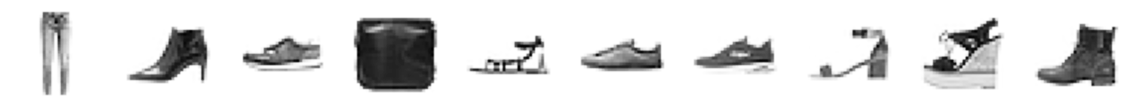

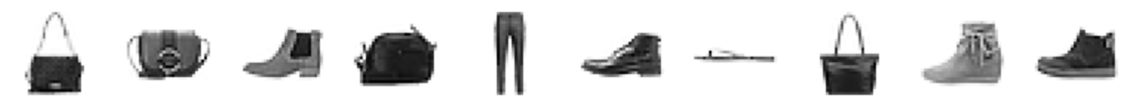

In [15]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(batch_size, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().detach().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()

for loader in [unlabeled_loader, labeled_loader]:
    if loader == unlabeled_loader:
        for x in loader:
            show_images(x)
            break
    else:
        for x, y in loader:
            show_images(x)
            break

# Model Implementation

In [16]:
import torch.nn.functional as F
# # hyper parameters
x_dim = 32*32
# hidden_dim = 500

lr = 1e-3
epochs = 100


class Encoder(nn.Module):
    def __init__(self, latent_dim, imgChannels=1, featureDim=128*26*26):
        super(Encoder, self).__init__()
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 32, 3)
        self.encConv2 = nn.Conv2d(32, 64, 3)
        self.encConv3 = nn.Conv2d(64, 128, 3)
        self.encFC1 = nn.Linear(featureDim, latent_dim)
        self.encFC2 = nn.Linear(featureDim, latent_dim)
        
    def forward(self, x):
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = F.relu(self.encConv3(x))
        x = x.view(-1, 128*26*26)
        mu = self.encFC1(x)
        log_sigma = self.encFC2(x)
        z = self.reparameterize(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterize(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma)
        z = mu + sigma * eps
        
        return z


class Decoder(nn.Module):
    def __init__(self, latent_dim, imgChannels=1, featureDim=128*26*26):
        super(Decoder, self).__init__()
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(latent_dim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(128, 64, 3)
        self.decConv2 = nn.ConvTranspose2d(64, 32, 3)
        self.decConv3 = nn.ConvTranspose2d(32, imgChannels, 3)
        self.fc_output = nn.Linear(1*32*32, 32*32)
        
    def forward(self, z):
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 128, 26, 26)
        x = F.relu(self.decConv1(x))
        x = F.relu(self.decConv2(x))
        x = self.decConv3(x)
        x = x.view(-1, 1*32*32)

        return torch.sigmoid(self.fc_output(x))

In [17]:
latent_dim = 16

# Initialize the VAE
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, z, mu, log_sigma

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

In [18]:
# Define the loss function
def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

# Model Training

In [19]:
optimizer = Adam(vae.parameters(), lr=lr)

print("Training VAE for anomaly detection...")
vae.train()

avg_losses = []
recons_losses = []
kl_losses = []

for epoch in range(epochs):
    overall_loss = 0.0
    overall_reconstr_loss = 0.0
    overall_kl_loss = 0.0
    for batch_idx, x in enumerate(unlabeled_loader):
        x = x.view(batch_size, 1, 32, 32)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        out, z, mu, log_sigma = vae(x)
        # sigma = torch.exp(logVar/2)
        # log_sigma = torch.log(sigma)
        x = x.view(batch_size, x_dim)
        # print(x.shape)
        # print(out.shape)
        loss, reconstr_loss, kl_loss = loss_function(x, out, mu, log_sigma)
        #kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        #loss = F.binary_cross_entropy(out, x, size_average=False) + kl_divergence
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    avg_losses.append(overall_loss / n_datapoints)
    recons_losses.append(overall_reconstr_loss / n_datapoints)
    kl_losses.append(overall_kl_loss / n_datapoints)
    #print('Epoch {}: Loss {}'.format(epoch, loss))
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Training VAE for anomaly detection...
	Epoch 1 	Average Loss:  53.3275595363779 	Reconstruction Loss: 49.15092301180924 	KL Loss: 4.1766364131332825
	Epoch 2 	Average Loss:  30.590751123612453 	Reconstruction Loss: 24.747995798707468 	KL Loss: 5.842755315478704
	Epoch 3 	Average Loss:  27.24460884712838 	Reconstruction Loss: 21.11173946424801 	KL Loss: 6.13286937581066
	Epoch 4 	Average Loss:  26.22939651076858 	Reconstruction Loss: 19.834668934943593 	KL Loss: 6.394727670087778
	Epoch 5 	Average Loss:  25.673367142253863 	Reconstruction Loss: 19.15763772736185 	KL Loss: 6.515729431388
	Epoch 6 	Average Loss:  25.21439397509954 	Reconstruction Loss: 18.603032042750062 	KL Loss: 6.611361927636342
	Epoch 7 	Average Loss:  24.942056012834822 	Reconstruction Loss: 18.21688775375543 	KL Loss: 6.7251682543662525
	Epoch 8 	Average Loss:  24.69458486667471 	Reconstruction Loss: 17.94163792908422 	KL Loss: 6.752946911668225
	Epoch 9 	Average Loss:  24.465773539303814 	Reconstruction Loss: 17.63

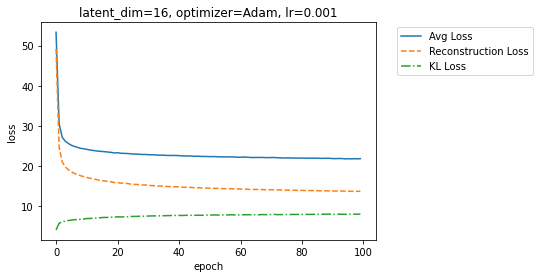

In [20]:
# plotting of losses
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(avg_losses, label='Avg Loss', linestyle="-")
plt.plot(recons_losses, label="Reconstruction Loss", linestyle="--")
plt.plot(kl_losses, label="KL Loss", linestyle="-.")
plt.title(f"latent_dim=16, optimizer=Adam, lr={lr}")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# VAE Evaluation: Anomaly detection

In [21]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

In [22]:
vae.eval()

representative_elbo_1 = []
representative_elbo_2 = []
representative_rec_1 = []
representative_rec_2 = []

with torch.no_grad():
    for x, _ in representative_loader_1:
        x = x.view(4, 1, 32, 32)
        x = x.to(DEVICE)
        x_rec, z, mu, log_sigma = vae(x)
        # sigma = torch.exp(logVar/2)
        # log_sigma = torch.log(sigma)
        # print(x.shape)
        # print(x_rec.shape)
        x = x.view(4, x_dim)
        x_rec = x_rec.view(4, x_dim)
        elbo, rec, kl = elbo_elementwise(x, x_rec, mu, log_sigma)
        representative_elbo_1.append(elbo.cpu().numpy())
        representative_rec_1.append(rec.cpu().numpy())
    
    for x, _ in representative_loader_2:
        x = x.view(4, 1, 32, 32)
        x = x.to(DEVICE)
        x_rec, z, mu, log_sigma = vae(x)
        # sigma = torch.exp(logVar/2)
        # log_sigma = torch.log(sigma)
        x = x.view(4, x_dim)
        x_rec = x_rec.view(4, x_dim)
        elbo, rec, kl = elbo_elementwise(x, x_rec, mu, log_sigma)
        representative_elbo_2.append(elbo.cpu().numpy())
        representative_rec_2.append(rec.cpu().numpy())
    
representative_elbo_1 = np.concatenate(representative_elbo_1, 0)
representative_elbo_2 = np.concatenate(representative_elbo_2, 0)
representative_rec_1 = np.concatenate(representative_rec_1, 0)
representative_rec_2 = np.concatenate(representative_rec_2, 0)

In [23]:
representative_elbo_2

array([-598.38165, -612.9275 , -612.45856, ..., -616.4572 , -598.6575 ,
       -596.655  ], dtype=float32)

In [24]:
representative_dataset_2[0][1]

tensor([1., 0., 0., 0., 0., 0.])

In [25]:
representative_labels_1 = []
for i in range(len(representative_dataset_1)):
    if representative_dataset_1[i][1][5] == 1:
        representative_labels_1.append(1)
    else:
        representative_labels_1.append(0)

In [26]:
scores_1 = - representative_elbo_1
scores_1 = (scores_1 - scores_1.min())/(scores_1.max()-scores_1.min())

In [27]:
hist1 = - representative_elbo_1
hist2 = - representative_elbo_2

# Density plots

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


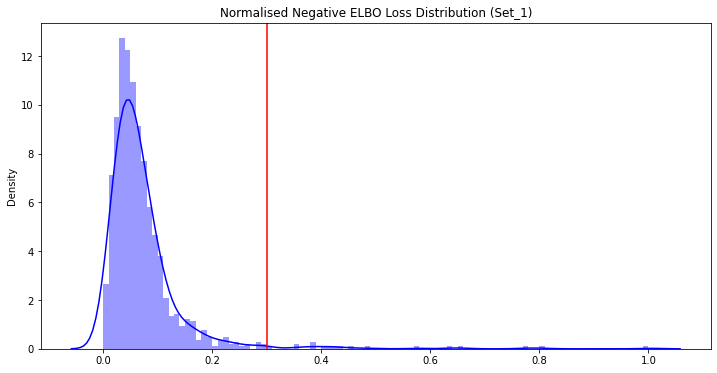

In [28]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Normalised Negative ELBO Loss Distribution (Set_1)')
sns.distplot(scores_1,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
# plt.axvline(lower_threshold, 0.0, 10, color='b')

In [29]:
scores_1_norm = np.where(scores_1 > 0.3, 1, 0)
print(confusion_matrix(representative_labels_1, scores_1_norm))

[[997   3]
 [ 37  15]]


In [30]:
normal_idx = np.where(scores_1_norm == 0)[0]
anomaly_idx = np.where(scores_1_norm == 1)[0]
len(normal_idx), len(anomaly_idx)

(1034, 18)

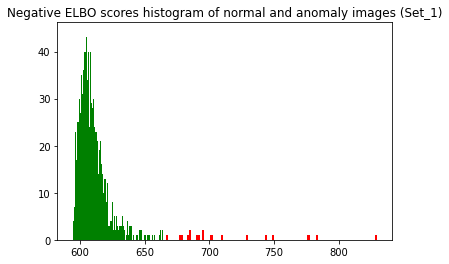

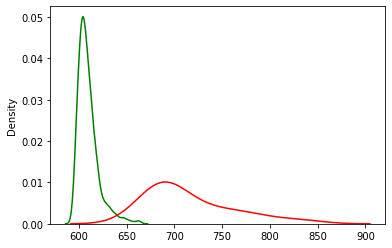

In [31]:
plt.hist(hist1[normal_idx], bins=100, color='green')
plt.hist(hist1[anomaly_idx], bins=100, color='red')
plt.title("Negative ELBO scores histogram of normal and anomaly images (Set_1)")
plt.show()

sns.kdeplot(hist1[normal_idx], color='green')
sns.kdeplot(hist1[anomaly_idx], color='red')
plt.show()

In [32]:
tn, fp, fn, tp = confusion_matrix(representative_labels_1, scores_1_norm).ravel()
(tn, fp, fn, tp)

(997, 3, 37, 15)

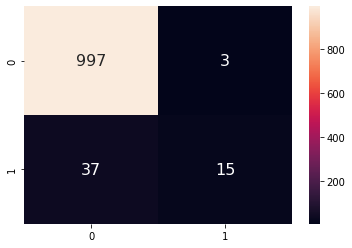

In [33]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

roc_auc=0.9233653846153846


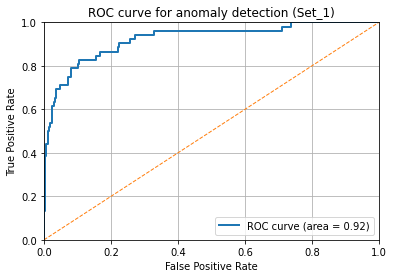

pr_auc=0.600286274439631


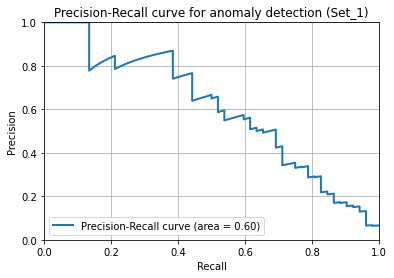

In [34]:
fpr, tpr, roc_thresholds = roc_curve(representative_labels_1, scores_1)
precision, recall, pr_thresholds = precision_recall_curve(representative_labels_1, scores_1)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

print(f'roc_auc={roc_auc}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for anomaly detection (Set_1)')
plt.legend(loc='lower right')
plt.show()


print(f'pr_auc={pr_auc}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.title('Precision-Recall curve for anomaly detection (Set_1)')
plt.legend(loc='lower left')
plt.show()

In [35]:
roc_auc_score(representative_labels_1, scores_1)

0.9233653846153846

In [36]:
representative_labels_2 = []
for i in range(len(representative_dataset_2)):
    if representative_dataset_2[i][1][5] == 1:
        representative_labels_2.append(1)
    else:
        representative_labels_2.append(0)

In [37]:
scores_2 = - representative_elbo_2
scores_2 = (scores_2 - scores_2.min())/(scores_2.max()-scores_2.min())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


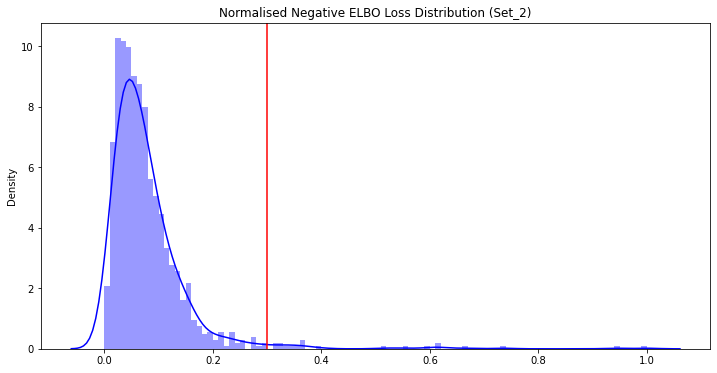

In [38]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Normalised Negative ELBO Loss Distribution (Set_2)')
sns.distplot(scores_2,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
# plt.axvline(lower_threshold, 0.0, 10, color='b')

In [39]:
scores_2_norm = np.where(scores_2 > 0.3, 1, 0)
print(confusion_matrix(representative_labels_2, scores_2_norm))

[[999   1]
 [ 33  19]]


In [40]:
tn, fp, fn, tp = confusion_matrix(representative_labels_2, scores_2_norm).ravel()
(tn, fp, fn, tp)

(999, 1, 33, 19)

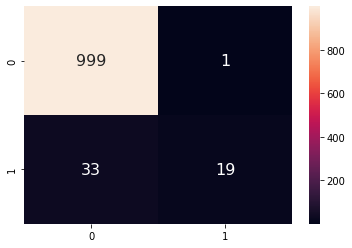

In [41]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

In [42]:
normal_idx = np.where(scores_2_norm == 0)[0]
anomaly_idx = np.where(scores_2_norm == 1)[0]
len(normal_idx), len(anomaly_idx)

(1032, 20)

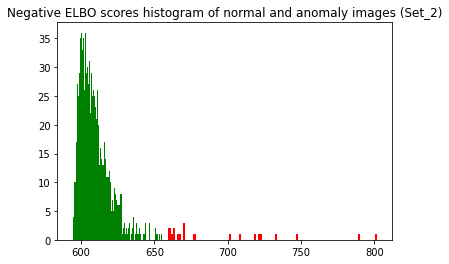

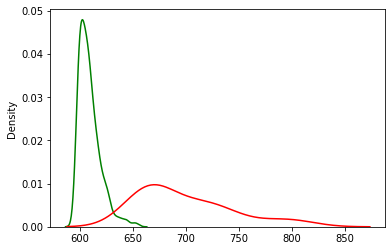

In [43]:
plt.hist(hist2[normal_idx], bins=100, color='green')
plt.hist(hist2[anomaly_idx], bins=100, color='red')
plt.title("Negative ELBO scores histogram of normal and anomaly images (Set_2)")
plt.show()

sns.kdeplot(hist2[normal_idx], color='green')
sns.kdeplot(hist2[anomaly_idx], color='red')
plt.show()

roc_auc=0.9300576923076923


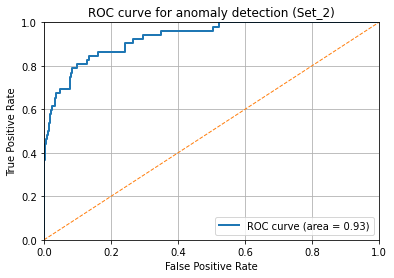

pr_auc=0.648549455433485


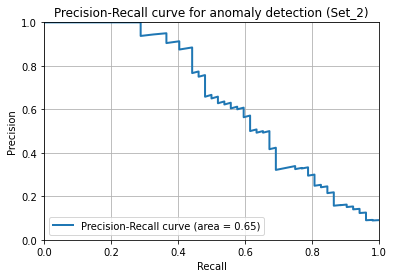

In [44]:
fpr, tpr, roc_thresholds = roc_curve(representative_labels_2, scores_2)
precision, recall, pr_thresholds = precision_recall_curve(representative_labels_2, scores_2)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

print(f'roc_auc={roc_auc}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('ROC curve for anomaly detection (Set_2)')
plt.legend(loc='lower right')
plt.show()


print(f'pr_auc={pr_auc}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.title('Precision-Recall curve for anomaly detection (Set_2)')
plt.legend(loc='lower left')
plt.show()

# Task 4.2 : Latent space visualization

In [45]:
encoder = Encoder(latent_dim=2)
decoder = Decoder(latent_dim=2)

vae4_2 = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

In [46]:
epochs = 100
optimizer = Adam(vae4_2.parameters(), lr=lr)

print("Training VAE for latent_dim = 2...")
vae4_2.train()

avg_losses = []
recons_losses = []
kl_losses = []

for epoch in range(epochs):
    overall_loss = 0.0
    overall_reconstr_loss = 0.0
    overall_kl_loss = 0.0
    for batch_idx, x in enumerate(unlabeled_loader):
        x = x.view(batch_size, 1, 32, 32)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        out, z, mu, log_sigma = vae4_2(x)
        # sigma = torch.exp(logVar/2)
        # log_sigma = torch.log(sigma)
        x = x.view(batch_size, x_dim)
        # print(x.shape)
        # print(out.shape)
        loss, reconstr_loss, kl_loss = loss_function(x, out, mu, log_sigma)
        #kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        #loss = F.binary_cross_entropy(out, x, size_average=False) + kl_divergence
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    avg_losses.append(overall_loss / n_datapoints)
    recons_losses.append(overall_reconstr_loss / n_datapoints)
    kl_losses.append(overall_kl_loss / n_datapoints)
    #print('Epoch {}: Loss {}'.format(epoch, loss))
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Training VAE for latent_dim = 2...
	Epoch 1 	Average Loss:  53.31995924076979 	Reconstruction Loss: 50.59917181655707 	KL Loss: 2.7207875468417946
	Epoch 2 	Average Loss:  31.183973761009895 	Reconstruction Loss: 26.71112628951496 	KL Loss: 4.472847457355514
	Epoch 3 	Average Loss:  29.079033448208254 	Reconstruction Loss: 24.44698061202944 	KL Loss: 4.632052837357097
	Epoch 4 	Average Loss:  28.253492766273528 	Reconstruction Loss: 23.585264449543015 	KL Loss: 4.668228359148769
	Epoch 5 	Average Loss:  27.836036881259048 	Reconstruction Loss: 23.10034160834942 	KL Loss: 4.735695257591925
	Epoch 6 	Average Loss:  27.480239323796454 	Reconstruction Loss: 22.708729045381876 	KL Loss: 4.771510260740302
	Epoch 7 	Average Loss:  27.157959286015927 	Reconstruction Loss: 22.35147966657366 	KL Loss: 4.806479619442266
	Epoch 8 	Average Loss:  27.015878208705356 	Reconstruction Loss: 22.205925062024914 	KL Loss: 4.809953125471314
	Epoch 9 	Average Loss:  26.80561714790963 	Reconstruction Loss: 2

In [47]:
y = np.argmax(labeled_data_y, axis=1)
dataset_42 = LabelDataset(labeled_data_X, y)
labeled_loader_42 = torch.utils.data.DataLoader(dataset_42, batch_size=batch_size, **kwargs)

In [48]:
vae4_2.eval()

x_original_list = []
y_list = []
x_reconstr_list = []
z_list = []
log_sigma_list = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(labeled_loader_42)):
        x = x.view(batch_size, 1, 32, 32)
        x = x.to(DEVICE)
        
        x_reconstr, z, mu, log_sigma = vae4_2(x)
        x_original_list.append(x)
        y_list.append(y)
        x_reconstr_list.append(x_reconstr)
        z_list.append(z)
        log_sigma_list.append(log_sigma)

100%|██████████| 20/20 [00:00<00:00, 76.07it/s]


In [49]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy(), cmap="Greys_r")

In [50]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(batch_size, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys_r")
        ax[idx].axis('off')

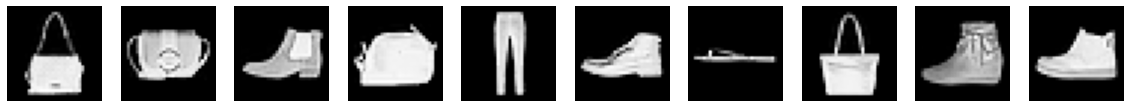

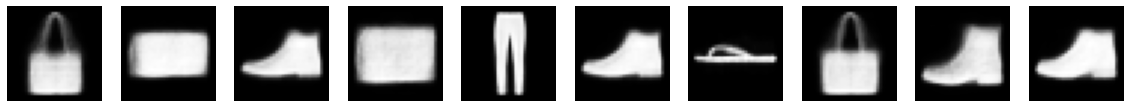

In [51]:
batch_idx = 0
show_images(x_original_list[batch_idx])
show_images(x_reconstr_list[batch_idx])

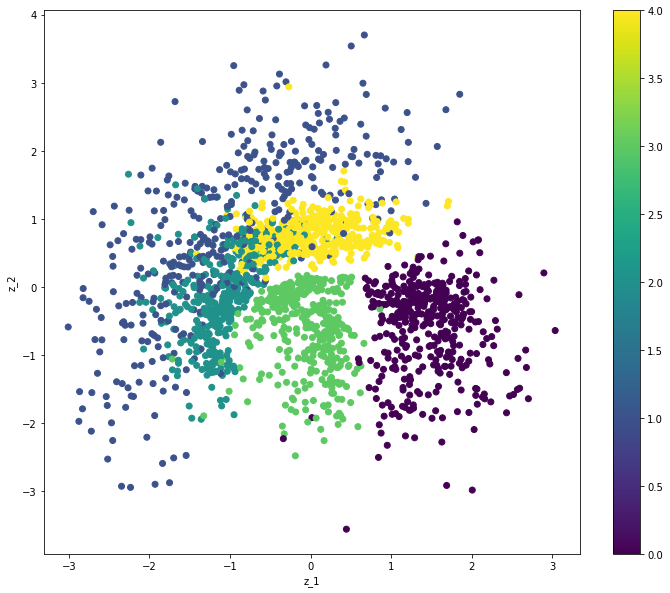

In [52]:
plt.figure(figsize=(12, 10))
for z, y in zip(z_list, y_list):
    z = z.cpu().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y)
plt.colorbar()
plt.xlabel("z_1")
plt.ylabel("z_2")
plt.show()

# Task 4.3 : VAE classification (Transfer learning)

In [53]:
# Freeze the previously trained VAE encoder
for param in vae.encoder.parameters():
    param.requires_grad = False

In [54]:
class VAE4_3(nn.Module):
    def __init__(self):
        super(VAE4_3, self).__init__()
        self.vae = vae.encoder
        self.fc = nn.Linear(16, 256)
        self.fc1 = nn.Linear(256, 512)
        self.fcOut = nn.Linear(512, 5)
        self.softmax = nn.Softmax()
                
    def forward(self, x):
        z, mu, log_sigma = self.vae(x)
        output = self.fc(z)
        output = self.fc1(output)
        return self.softmax(self.fcOut(output))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vae4_3 = VAE4_3().to(DEVICE)

In [55]:
anomaly_1_index = np.argmax(representative_set_1_y, axis=1)
rep_1_X = np.delete(representative_set_1_X, np.where(anomaly_1_index==5), axis=0)
rep_1_y = np.delete(representative_set_1_y, np.where(anomaly_1_index==5), axis=0)
rep_1_y = np.delete(rep_1_y, 5, 1)

In [56]:
anomaly_2_index = np.argmax(representative_set_2_y, axis=1)
rep_2_X = np.delete(representative_set_2_X, np.where(anomaly_2_index==5), axis=0)
rep_2_y = np.delete(representative_set_2_y, np.where(anomaly_2_index==5), axis=0)
rep_2_y = np.delete(rep_2_y, 5, 1)

In [57]:
data_X = np.concatenate((labeled_data_X, rep_1_X), axis=0)
data_y = np.concatenate((labeled_data_y, rep_1_y), axis=0)

In [58]:
from sklearn.model_selection import train_test_split

# choose a training dataset size and further divide it into train and validation set 80:20
train_data, val_data, train_label, val_label = train_test_split(data_X, data_y, train_size = 0.8, random_state=13)

# We do data transformations only on training data.
#train_data, train_label = sample_and_transform(train_data, train_label, sample_rate = 0.5)

train_dataset=LabelDataset(train_data,train_label)
val_dataset = LabelDataset(val_data,val_label)
test_dataset = LabelDataset(rep_2_X, rep_2_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [59]:
class_loss = nn.CrossEntropyLoss()

In [60]:
optimizer = Adam(vae4_3.parameters(), lr=1e-3)
epochs = 100
print("Training VAE for classification...")

train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    vae4_3.train()
    for img, label in train_loader:
        img = img.view(batch_size, 1, 32, 32)
        img = img.to(DEVICE)

        label = label.to(DEVICE)

        output_en = vae4_3(img)
        
        loss = class_loss(output_en, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    avg_loss = running_loss/len(train_loader)
    train_losses.append(avg_loss)

    # ============ Validation ============ #

    val_running_loss = 0.0
    with torch.no_grad():
        vae4_3.eval()
        for val_img, label in val_loader:
            val_img = val_img.view(batch_size, 1, 32, 32)
            val_img = val_img.to(DEVICE)

            label = label.to(DEVICE)
            output_en = vae4_3(val_img)
        
            loss = class_loss(output_en, label)

            val_running_loss += loss.item()
            
        avg_val_loss = val_running_loss/len(val_loader)
        val_losses.append(avg_val_loss)

    print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}'
            .format(epoch+1, epochs, avg_loss, avg_val_loss))
    
print("Training complete!")

Training VAE for classification...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch [1/100], train_loss: 1.2556, val_loss: 1.0899
Epoch [2/100], train_loss: 1.0827, val_loss: 1.0737
Epoch [3/100], train_loss: 1.0699, val_loss: 1.0645
Epoch [4/100], train_loss: 1.0618, val_loss: 1.0649
Epoch [5/100], train_loss: 1.0651, val_loss: 1.0611
Epoch [6/100], train_loss: 1.0605, val_loss: 1.0684
Epoch [7/100], train_loss: 1.0579, val_loss: 1.0585
Epoch [8/100], train_loss: 1.0524, val_loss: 1.0723
Epoch [9/100], train_loss: 1.0536, val_loss: 1.0492
Epoch [10/100], train_loss: 1.0629, val_loss: 1.0628
Epoch [11/100], train_loss: 1.0497, val_loss: 1.0677
Epoch [12/100], train_loss: 1.0543, val_loss: 1.0605
Epoch [13/100], train_loss: 1.0492, val_loss: 1.0580
Epoch [14/100], train_loss: 1.0530, val_loss: 1.0537
Epoch [15/100], train_loss: 1.0560, val_loss: 1.0534
Epoch [16/100], train_loss: 1.0457, val_loss: 1.0446
Epoch [17/100], train_loss: 1.0538, val_loss: 1.0579
Epoch [18/100], train_loss: 1.0537, val_loss: 1.0525
Epoch [19/100], train_loss: 1.0521, val_loss: 1.0468
Ep

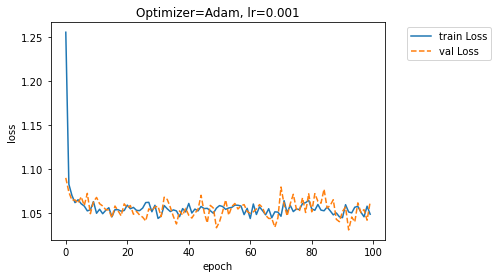

In [61]:
# plotting of losses
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='train Loss', linestyle="-")
plt.plot(val_losses, label="val Loss", linestyle="--")
plt.title(f"Optimizer=Adam, lr={lr}")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [62]:
optimizer = Adam(vae4_3.parameters(), lr=1e-3)
print("Testing VAE for classification...")

avg_test_losses = []
test_accuracy = []

test_running_loss = 0.0
with torch.no_grad():
    vae4_3.eval()
    for test_img, label in test_loader:
        curr_test_acc = 0
        test_img = test_img.view(batch_size, 1, 32, 32)
        test_img = test_img.to(DEVICE)

        label = label.to(DEVICE)

        output_en = vae4_3(test_img)
       
        loss = class_loss(output_en, label)
        test_running_loss += loss.item()
        output = np.zeros_like(output_en.cpu())
        output[np.arange(len(output_en.cpu())), output_en.cpu().argmax(1)] = 1
        output = torch.from_numpy(output).to(DEVICE)
        for i in range(len(output)):
            if(torch.all(output[i].eq(label[i]))):
                curr_test_acc += 1
        
        curr_test_acc = curr_test_acc/batch_size
        test_accuracy.append(curr_test_acc)
        
    avg_test_loss = test_running_loss/len(test_loader)

print('avg_test_loss: {:.4f}, avg_test_acc: {:.2f}'
        .format(avg_test_loss, np.mean(test_accuracy)))

Testing VAE for classification...
avg_test_loss: 1.0634, avg_test_acc: 0.84


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
